In [ ]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 5.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 109.3MB 86kB/s 
     |████████████████████████████████| 491kB 45.9MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 3.2MB 41.0MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [ ]:
cd '/content/drive/MyDrive/Mammographic'

/content/drive/.shortcut-targets-by-id/1OhozUtMOASdwL2TG6wvn8dChDU-HPnEu/Mammographic


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.image
import glob
import scipy.misc
from PIL import Image
#import imgaug 
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import imageio

In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()
ROOT_DIR = ROOT_DIR+"/Mask_r_cnn"

MAMOGRAM_IMAGE_DIR = "/scans/pseudo_color_image/" #Path of the mammograms
MAMOGRAM_MASK_DIR = "/scans/preprocessed_mask/"# Path of the ground truth masks


# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join("/content/drive/MyDrive/Mammographic", "logs")#Log directory for saving the weights
DEMO_SAVE_DIR = "/scans/seg_mask/"# path to save the segmentation masks

Using TensorFlow backend.


In [ ]:
############################################################
#  Configurations
############################################################


class MamogramConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mamogram"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + lesion

    # Number of training steps per epoch,set to the number of training data here
    STEPS_PER_EPOCH = 5

    # Number of validation steps after each round of training
    VALIDATION_STEPS = 2
    # Resize mode: "none" or "square"

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Skip detections with < DETECTION_MIN_CONFIDENCE
    DETECTION_MIN_CONFIDENCE = 0.965 # alter this during testing to generate different TPR at different FPI
    # 0.7 0.75 0.8 0.85 0.9

In [ ]:
############################################################
#  Dataset
############################################################

class MamogramDataset(utils.Dataset):

    def load_mamogram(self, subset):
        """This method loads the actual image
        subset is either "train" or "val" depending on whether the image is part of the training or validation datasets 
        """
        # Add classes. We have only one class to add.
        # These are the things that will be segmented
        self.add_class("mamogram", 1, "lesion")

        # Train or validation dataset?

        #list all the files in the directory with the mamogram images
        files = os.listdir(ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset + "/")
        
        for fname in files:            
            self.add_image("mamogram", image_id=fname, 
                           path=ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset +"/"+ fname, subset=subset, fname=fname)


    def load_mask(self, image_id):
        """load the instance masks for an image.
        Returns:
        a tuple containing:
        masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        use dtype=np.int32
        """
        image_info = self.image_info[image_id]
        info = self.image_info[image_id]
        fname = info['fname']
       
        files = glob.glob(ROOT_DIR + MAMOGRAM_MASK_DIR + info['subset']+"/" + fname[0:-4] + "*")
        

        masks = []
        for i in range(0, len(files)):
            #print(i)
            data = skimage.io.imread(files[i])
            
            if data.ndim != 1:
                data = skimage.color.rgb2gray(data)
          
            singleMask = data
            if i == 0:
                masks = np.zeros((singleMask.shape[0], singleMask.shape[1], len(files)))
            masks[:,:,i] = singleMask

        instanceMaskMap = np.array(np.ones([masks.shape[-1]], dtype=np.int32))
        
        return (masks.astype(np.bool), instanceMaskMap)


        #class_ids = np.array([self.class_names.index(s[0]) for s in fname])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
         #this is VERY important: array of class ids in the order that they appear in bigdata
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
		Taken from utils.py, any refinements we need can be done here
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        return info["path"]

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = MamogramDataset()
    dataset_train.load_mamogram("train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = MamogramDataset()
    dataset_val.load_mamogram("val")
    dataset_val.prepare()




    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    aug = iaa.Sequential([
        iaa.OneOf([iaa.Fliplr(0.5),
                   iaa.Flipud(0.5),
                   iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
    ])

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")

    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=3,augmentation=aug,
                layers='heads')

In [ ]:
def segment(model, imPath):
    
    image = skimage.io.imread(imPath)

    fname = imPath.split('/')[-1]
    mrcnnData = model.detect([image], verbose=1)
       # documentation for model.detect:
       # """Runs the detection pipeline.

       # images: List of images, potentially of different sizes.

       # Returns a list of dicts, one dict per image. The dict contains:
       # rois: [N, (y1, x1, y2, x2)] detection bounding boxes
       # class_ids: [N] int class IDs
       # scores: [N] float probability scores for the class IDs
       # masks: [H, W, N] instance binary masks
       # """

    mrcnnData = mrcnnData[0] #model.detect takes a list of images, but here we only provide one image so the output is a list with just one element

    masks = mrcnnData['masks']
    print(masks.shape[2])
    for i in range(0, masks.shape[2]):
        #iterate through the masks
        maskSingle = np.squeeze(masks[:, :, i])
        file_name =ROOT_DIR+ DEMO_SAVE_DIR + "demo_mask_" + str(i) + "_" + fname + "_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        

        #scipy.misc.imsave(file_name, maskSingle.astype(np.int64))
        plt.imshow(maskSingle.astype(np.int8))
        #scipy.misc.imsave(file_name, maskSingle.astype(np.int64)) 
        matplotlib.image.imsave(file_name, maskSingle.astype(np.int64))
 


    print(mrcnnData)
    print("&&&&&&&&&&&: "+str(mrcnnData['rois']))
    print("&&&&&&&&&&&: "+str(mrcnnData['class_ids']))
    print("&&&&&&&&&&&: "+str(mrcnnData['scores']))

    return

def segmentWrapper(model, directory):
    """wrapper function for segment to take many images as an input, calls segment() on everything in the directory"""
    files = os.listdir(directory)
    for f in files:
        segment(model, directory + '/' + f)

def overlayResult(image, mask):
	"""Function to overlay segmentation mask on an image.
	usage: image_var = overlayResult(image, dict['masks'] || masks_var)
	
	image: RGB or grayscale image [height, width, 1 || 3].
	mask: segmentation mask [height, width, instance_count]
	
	returns resulting image.
	"""
	# Image is already in grayscale so we skip converting it
	# May need to create 3 dimensions if single dimension image though so
	# will add this as a placeholder
	gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
	# Copy color pixels from the original color image where mask is set
	if mask.shape[-1] > 0:
		#collapse masks into one layer
		mask = (np.sum(mask, -1, keepdims=True) >= 1)
		overlay = np.where(mask, image, gray).astype(np.uint8)
	else:
		overlay = gray.astype(np.uint8)
		
	return overlay

In [ ]:
##########Cross-------- Check  training 

 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

    # Validation dataset
dataset_val = MamogramDataset()
dataset_val.load_mamogram("val")
dataset_val.prepare()

config = MamogramConfig()

model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)


weights_path ='/content/drive/MyDrive/Mammographic/logs/mask_rcnn_mamogram_weights.h5'

model.load_weights(weights_path, by_name=True)

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False

In [ ]:
##########Cross-------- Check  training 

 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

    # Validation dataset
dataset_val = MamogramDataset()
dataset_val.load_mamogram("val")
dataset_val.prepare()

config = MamogramConfig()

model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)


weights_path ='/content/drive/MyDrive/Mammographic/logs/mask_rcnn_mamogram_weights.h5'

model.load_weights(weights_path, by_name=True)

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False

Processing 1 images
image                    shape: (681, 681, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
{'rois': array([[267, 468, 324, 530]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9939551], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        

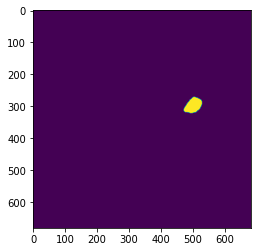

In [ ]:
config = MamogramConfig()
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
weights_path ='/content/drive/MyDrive/Mammographic/logs/mask_rcnn_mamogram_weights.h5'

model.load_weights(weights_path, by_name=True)

segment(model, '/content/drive/MyDrive/Mammographic/Mask_r_cnn/scans/pseudo_color_image/22580192_5530d5782fc89dd7_MG_R_CC_ANON.png')

In [ ]:
config = MamogramConfig()
#config.display()

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True)
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mammographic/logs/mamogram20210411T1840/mask_rcnn_mamogram_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du



Epoch 1/3
4/5 [=======================>......] - ETA: 50s - loss: 156.5887 - rpn_class_loss: 23.1618 - rpn_bbox_loss: 133.4269 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


5/5 [==============================] - 285s 57s/step - loss: 155.8546 - rpn_class_loss: 22.1052 - rpn_bbox_loss: 133.7494 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 289.6631 - val_rpn_class_loss: 15.7631 - val_rpn_bbox_loss: 273.9000 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/3
5/5 [==============================] - 222s 44s/step - loss: 205.2084 - rpn_class_loss: 8.7118 - rpn_bbox_loss: 196.4966 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 263.3696 - val_rpn_class_loss: 1.1882 - val_rpn_bbox_loss: 262.1815 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/3
5/5 [==============================] - 223s 45s/step - loss: 242.0677 - rpn_class_loss: 0.3595 - rpn_bbox_loss: 241.7082 - mrcnn_class_loss: 2.3842e-08 - mrcnn_bbox_loss: 0.0000e+00 - mrcn

In [ ]:
config = MamogramConfig()
#config.display()

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True)
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mammographic/logs/mamogram20210429T1712/mask_rcnn_mamogram_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du



Epoch 1/3
4/5 [=======================>......] - ETA: 1:09 - loss: 157.4555 - rpn_class_loss: 22.7847 - rpn_bbox_loss: 134.6707 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


5/5 [==============================] - 406s 81s/step - loss: 157.5548 - rpn_class_loss: 21.6334 - rpn_bbox_loss: 135.9214 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 282.8493 - val_rpn_class_loss: 15.0273 - val_rpn_bbox_loss: 267.8220 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/3
5/5 [==============================] - 337s 67s/step - loss: 212.3183 - rpn_class_loss: 8.4674 - rpn_bbox_loss: 203.8509 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 271.0268 - val_rpn_class_loss: 1.1411 - val_rpn_bbox_loss: 269.8857 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/3
5/5 [==============================] - 329s 66s/step - loss: 245.1459 - rpn_class_loss: 0.3709 - rpn_bbox_loss: 244.7750 - mrcnn_class_loss: 2.3842e-08 - mrcnn_bbox_loss: 0.0000e+00 - mrcn

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [ ]:
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [ ]:
 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

config = MamogramConfig()

model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)


weights_path ='/content/drive/MyDrive/Mammographic/logs/mask_rcnn_mamogram_weights.h5'

model.load_weights(weights_path, by_name=True)


In [ ]:
train_mAP = evaluate_model(dataset_train, model, config)
print("Train mAP: %.3f" % train_mAP)

ValueError: ignored

In [ ]:
##  Now run testing  using command 

In [ ]:
!python mammo.py segment --weights=logs/mask_rcnn_mamogram_weights.h5 --image='/content/drive/MyDrive/Mammographic/Mask_r_cnn/scans/pseudo_color_image/22580192_5530d5782fc89dd7_MG_R_CC_ANON.png'

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
##########Cross-------- Check  training 

 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

    # Validation dataset
dataset_val = MamogramDataset()
dataset_val.load_mamogram("val")
dataset_val.prepare()

config = MamogramConfig()

model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)


weights_path ='/content/drive/MyDrive/Mammographic/logs/mask_rcnn_mamogram_weights.h5'

model.load_weights(weights_path, by_name=True)

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 11   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  2   0   1]
  [ 17   0  12]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 55   0  34]
  [ 70   0  39]
  [ 83   0  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [113   3  87]
  [117   2  89]
  [130   2  95]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 78   0  44]
  [ 85   0  50]
  [ 93   0  54]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 18   0   0]
  [ 21   0   0]
  [ 36   0   0]]] [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False

In [ ]:
config = MamogramConfig()
#config.display()

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True)
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mammographic/logs/mamogram20210428T2010/mask_rcnn_mamogram_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du



Epoch 1/3
4/5 [=======================>......] - ETA: 1:07 - loss: 159.9972 - rpn_class_loss: 23.1611 - rpn_bbox_loss: 136.8361 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


5/5 [==============================] - 396s 79s/step - loss: 158.1844 - rpn_class_loss: 22.1317 - rpn_bbox_loss: 136.0527 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 277.9507 - val_rpn_class_loss: 14.8308 - val_rpn_bbox_loss: 263.1200 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/3
5/5 [==============================] - 324s 65s/step - loss: 210.5771 - rpn_class_loss: 8.6134 - rpn_bbox_loss: 201.9637 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 266.8801 - val_rpn_class_loss: 1.1524 - val_rpn_bbox_loss: 265.7276 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/3
5/5 [==============================] - 331s 66s/step - loss: 247.8148 - rpn_class_loss: 0.3833 - rpn_bbox_loss: 247.4315 - mrcnn_class_loss: 2.3842e-08 - mrcnn_bbox_loss: 0.0000e+00 - mrcn